In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

import warnings; warnings.simplefilter('ignore')
import numpy as np
from scipy.io import arff
import pandas as pd
from sklearn.metrics import mean_squared_error,r2_score
from keras.optimizers import RMSprop, SGD, Adam
from keras.layers import Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from keras import Sequential
from keras.layers import Dense,Lambda, BatchNormalization
from keras.optimizers import SGD, Adagrad, Adam
from sklearn.utils import shuffle
from keras.models import Model
from keras import backend as K

from time import time
from keras.models import load_model


/home/dcasals/rnn/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/home/dcasals/rnn/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/dcasals/rnn/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


1 Physical GPUs, 1 Logical GPUs


Using TensorFlow backend.


In [2]:
def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

def rmse(y_true, y_pred):
    return K.exp(K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)))

def coeff_determination_simple(y_true, y_pred):
    SS_res =  np.sum(np.square( y_true - y_pred )) 
    SS_tot = np.sum(np.square( y_true - np.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )


In [3]:
def plot_history(history, title=''):
    plot_r2 = {'coeff_determination': history.history['coeff_determination'], 'val_coeff_determination': history.history['val_coeff_determination']}
    plot_rmse = {'rmse': history.history['rmse'], 'val_rmse': history.history['val_rmse']}
    plot_mse = {'mean_squared_error': history.history['mean_squared_error'], 'val_mean_squared_error': history.history['val_mean_squared_error']}
    plot_mae = {'mean_absolute_error': history.history['mean_absolute_error'], 'val_mean_absolute_error': history.history['val_mean_absolute_error']}
    plot_loss = {'loss': history.history['loss'], 'val_loss': history.history['val_loss']}

    _ = pd.DataFrame(plot_r2).plot(figsize=(15, 5), title='{0} (Epoch v/s R2)'.format(title))
    _.set_xlabel("Epoch")
    _.set_ylabel("R2")
   
    _ = pd.DataFrame(plot_rmse).plot(figsize=(15, 5), title='{0} (Epoch v/s RMSE)'.format(title))
    _.set_xlabel("Epoch")
    _.set_ylabel("RMSE")
    
    _ = pd.DataFrame(plot_mse).plot(figsize=(15, 5), title='{0} (Epoch v/s MSE)'.format(title))
    _.set_xlabel("Epoch")
    _.set_ylabel("MSE")
    
    _ = pd.DataFrame(plot_mae).plot(figsize=(15, 5), title='{0} (Epoch v/s MAE)'.format(title))
    _.set_xlabel("Epoch")
    _.set_ylabel("MAE")

    _ = pd.DataFrame(plot_loss).plot(figsize=(15, 5), title='{0} (Epoch v/s Loss)'.format(title))
    _.set_xlabel("Epoch")
    _.set_ylabel("Loss")

<div style="background-color:rgb(174, 229, 202);">

**Se probará con datos en escala lineal, escalando los targets entre 0 y 1 para los Sigmoide de salida**

In [4]:
def train_svr_legacydata():
    from sklearn.svm import NuSVR
    from sklearn.preprocessing import StandardScaler
    from time import time
    sv = NuSVR(C=300, nu=0.3)

    scaler_yz = StandardScaler()
    scaler_yz = scaler_yz.fit(y_train)
    y_train_scaled_svr = scaler_yz.transform(y_train)
    y_val_scaled_svr = scaler_yz.transform(y_val)
    y_test_scaled_svr = scaler_yz.transform(y_test)

    t0=time()
    print("before train: Init time: {}".format(round(t0,3)))

    sv.fit(x_train, np.ravel(y_train_scaled_svr))
    t1=time()
    print("after train, finish time: {}".format(round(t1,3)))
    print("training time {}",format(round(t1-t0,3)))
    y_train_hat_svr = scaler_yz.inverse_transform(sv.predict(x_train).reshape(-1, 1))
    y_val_hat_svr = scaler_yz.inverse_transform(sv.predict(x_val).reshape(-1, 1))
    y_test_hat_svr = scaler_yz.inverse_transform(sv.predict(x_test).reshape(-1, 1))

    #MSE for valid
    mse_svr_curr = np.sqrt(mean_squared_error(y_train_hat_svr,y_train))
    mse_svr_val_curr = np.sqrt(mean_squared_error(y_val_hat_svr,y_val))
    mse_svr_test_curr = np.sqrt(mean_squared_error(y_test_hat_svr,y_test))

    scores_train_curr = sv.score(x_train, y_train_scaled_svr)
    scores_val_curr = sv.score(x_val,   y_val_scaled_svr)
    scores_test_curr = sv.score(x_test,   y_test_scaled_svr)

    print("MSE val: {}, MSE train {}, R2 val:{}, R2 train:{}".format(mse_svr_val_curr,mse_svr_curr,scores_val_curr,scores_train_curr))
    print("MSE test: {}, R2 test:{}".format(mse_svr_test_curr, scores_test_curr))
    return sv, mse_svr_curr,mse_svr_val_curr,mse_svr_test_curr,scores_train_curr,scores_val_curr, scores_test_curr

In [53]:
# sv, mse_svr_curr,mse_svr_val_curr,mse_svr_test_curr,scores_train_curr,scores_val_curr, scores_test_curr = train_svr_legacydata()

before train: Init time: 1583860488.59
after train, finish time: 1583860718.347
training time {} 229.757
MSE val: 534.5980007027844, MSE train 1279.9678402801212, R2 val:0.9409941381602975, R2 train:0.7355802127375316
MSE test: 263.38325810096956, R2 test:0.9851237894253988


In [33]:
###################### New MEthods ##########
def loadarff_data(url, drop_columns=[]):
    data = arff.loadarff(url)
    df = pd.DataFrame(data[0])
    print("Loading data")
    print("Removing columns",drop_columns)
    df = df.drop(columns=drop_columns)
    print("Shapes",df.shape)
    return df

def scale_log_data_targets(df, df_val, df_test):
    df = shuffle(df)
    df.reset_index(inplace=True, drop=True) 

    df_val = shuffle(df_val)
    df_val.reset_index(inplace=True, drop=True)

    df_test = shuffle(df_test)
    df_test.reset_index(inplace=True, drop=True)

    x_train = df.loc[:, df.columns != 'ex_time'].values
    y_train = df[['ex_time']].values
    
    x_val = df_val.loc[:, df_val.columns != 'ex_time'].values
    y_val = df_val[['ex_time']].values

    x_test = df_test.loc[:, df_test.columns != 'ex_time'].values
    y_test = df_test[['ex_time']].values

    y_val_log = np.log(y_val)
    y_train_log = np.log(y_train)
    y_test_log = np.log(y_test)

    y_train_log_min = np.min(y_train_log)
    y_train_min = np.min(y_train)

    y_train_log_max = np.max(y_train_log)
    y_train_max = np.max(y_train)

    print("targets min:{} max: {}".format(y_train_min, y_train_max))
    print("targets in log scale min:{} max: {}".format(y_train_log_min, y_train_log_max))
    return x_train, x_val, x_test , y_train, y_val, y_test, y_train_log, y_val_log, y_test_log

def normalize_target(y_train_log, y_val_log, y_test_log):
    """
    Normalize data using StandardScaler.
    
    return scaler object; values of train,val and test sets standarized. 
    """
    #Standarización del target
    scaler = StandardScaler()
    y_train_log_std = scaler.fit_transform(y_train_log)
    y_val_log_std = scaler.transform(y_val_log)
    y_test_log_std = scaler.transform(y_test_log)
    return scaler, y_train_log_std, y_val_log_std, y_test_log_std

def build_best_model(units, input_len= 34):
    print("Building Model with input length: {}".format(input_len))
    model = Sequential()
    model.add(Dense(units[0], input_shape=(input_len,), activation='relu',kernel_initializer='random_uniform'))
    model.add(Dense(units[1], activation='relu'))
    model.add(Dense(units[2], activation='relu'))
    model.add(Dense(1, activation='linear'))
    print(model.summary())
    return model

    return model, history

def train_best_model(model, x_train, y_train, x_val, y_val, epochs=250, verbose=False, optimizer=None):
    """
    Train and Dense Model with Keras. 
    x_train: Train data
    x_val: Validation data
    units: list with 3 values [Layer1units, Layer2units,Layer3units]
    optimizer: if None we use Stocastic Gradient Descent
    """
    if optimizer == None:
        optimizer = SGD(lr=0.001)
    # Set callback functions to early stop training and save the best model so far
    callbacks_best = [
        EarlyStopping(monitor='val_loss', patience=15),
        ModelCheckpoint(filepath='models_legacy/bestm_legacydata.hdf5', monitor='val_loss', save_best_only=True)
    ]
    t1 = time()
    print("Start training at : {}".format(round(t1,3)))
    model.compile(loss='mse', optimizer=optimizer, metrics=['mse','mae', coeff_determination, rmse])
    history = model.fit(x_train, y_train,
        epochs=epochs,
        verbose=verbose,
        validation_data=(x_val, y_val),
        callbacks=callbacks_best
    )
    t2 = time()
    print("End training at : {}. Traing time: {}".format(round(t2, 3), round(t2-t1, 3)))

    return model, history

def get_metrics(model, scaler, x_data, y_true_data, label_set="Data"):
    y_pred = np.exp(scaler.inverse_transform(model.predict(x_data).reshape(-1, 1)))
    rmse = np.sqrt(mean_squared_error(y_true_data, y_pred))
    r2 = r2_score(y_true_data, y_pred)
    print("RMSE "+label_set, rmse)
    print("R2 SCORE "+label_set, r2)
    return rmse, r2

def plot_history(history, metrics_list, start_at_epoch=0):
    for metric in metrics_list:
        plt.plot(history.history[metric][start_at_epoch:],label=metric)
    plt.legend()
    plt.title("Metrics by epochs(Start from epoch:{})".format(start_at_epoch))
    plt.show()

def train_complete_model(verbose_train=False,drop_columns=[],units=[85, 60, 60],optimizer=None):
    #load legacy data
    df        = loadarff_data('/home/dcasals/jupyter/mlproject/dataold/x_features.arff', drop_columns=drop_columns)
    data_val  = loadarff_data('/home/dcasals/jupyter/mlproject/dataold/xval_features.arff', drop_columns=drop_columns)
    data_test = loadarff_data('/home/dcasals/jupyter/mlproject/dataold/xtest_features.arff', drop_columns=drop_columns)
    
    #print columns
    print("Columns datasets", df.columns)
    #transform data and get in log scale
    x_train, x_val, x_test , y_train, y_val, y_test, y_train_log, y_val_log, y_test_log = scale_log_data_targets(df, data_val, data_test)
    print("Shape datasets x: {}".format(x_train.shape))
    print("Shape datasets xval: {}".format(x_val.shape))
    print("Shape datasets xtest: {}".format(x_test.shape))

    # scale target using StandarSacaler
    scalery, y_train_log_std, y_val_log_std, y_test_log_std = normalize_target(y_train_log, y_val_log, y_test_log)
    
    print(
    "Dimensiones de los datos: Cant ejemplos en train:{}, Val: {} Test: {}".
      format(x_train.shape[0], x_val.shape[0], x_test.shape[0])
     )
    #train with units by layer
    model = build_best_model(units=units, input_len=34 - len(drop_columns))
    best_model, history = train_best_model(model, x_train, y_train_log_std, x_val, y_val_log_std, epochs=150, verbose=verbose_train,optimizer=optimizer)
    
    #load weights for best model.
#     best_model = build_best_model(units=[85, 60, 60])
#     best_model.load_weights('models_legacy/bestm_legacydata.hdf5')
    rmse_train, r2_train = get_metrics(best_model, scalery, x_train, y_train, label_set=" Train ")
    rmse_val, r2_val     = get_metrics(best_model, scalery, x_val, y_val, label_set=" Val ")
    rmse_test, r2_test   = get_metrics(best_model, scalery, x_test, y_test, label_set=" Test ")
    plot_history(history, metrics_list=['loss','val_loss'],start_at_epoch=5)
    return best_model, scalery, rmse_train, rmse_val, rmse_test, r2_train, r2_val, r2_test

Loading data
Removing columns []
Shapes (1260, 35)
Loading data
Removing columns []
Shapes (420, 35)
Loading data
Removing columns []
Shapes (420, 35)
Columns datasets Index(['triple', 'bgp', 'join', 'leftjoin', 'union', 'filter', 'project',
       'distinct', 'treesize', 'pcs0', 'pcs1', 'pcs2', 'pcs3', 'pcs4', 'pcs5',
       'pcs6', 'pcs7', 'pcs8', 'pcs9', 'pcs10', 'pcs11', 'pcs12', 'pcs13',
       'pcs14', 'pcs15', 'pcs16', 'pcs17', 'pcs18', 'pcs19', 'pcs20', 'pcs21',
       'pcs22', 'pcs23', 'pcs24', 'ex_time'],
      dtype='object')
targets min:0.2 max: 34397.0
targets in log scale min:-1.6094379124341003 max: 10.445724630256212
Shape datasets x: (1260, 34)
Shape datasets xval: (420, 34)
Shape datasets xtest: (420, 34)
Dimensiones de los datos: Cant ejemplos en train:1260, Val: 420 Test: 420
Building Model with input length: 34
Model: "sequential_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
d

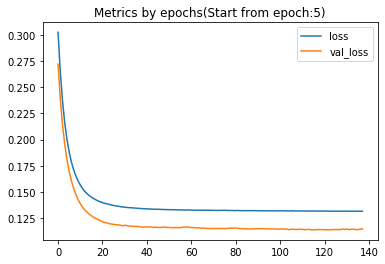

Loading data
Removing columns []
Shapes (1260, 35)
Loading data
Removing columns []
Shapes (420, 35)
Loading data
Removing columns []
Shapes (420, 35)
Columns datasets Index(['triple', 'bgp', 'join', 'leftjoin', 'union', 'filter', 'project',
       'distinct', 'treesize', 'pcs0', 'pcs1', 'pcs2', 'pcs3', 'pcs4', 'pcs5',
       'pcs6', 'pcs7', 'pcs8', 'pcs9', 'pcs10', 'pcs11', 'pcs12', 'pcs13',
       'pcs14', 'pcs15', 'pcs16', 'pcs17', 'pcs18', 'pcs19', 'pcs20', 'pcs21',
       'pcs22', 'pcs23', 'pcs24', 'ex_time'],
      dtype='object')
targets min:0.2 max: 34397.0
targets in log scale min:-1.6094379124341003 max: 10.445724630256212
Shape datasets x: (1260, 34)
Shape datasets xval: (420, 34)
Shape datasets xtest: (420, 34)
Dimensiones de los datos: Cant ejemplos en train:1260, Val: 420 Test: 420
Building Model with input length: 34
Model: "sequential_51"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
d

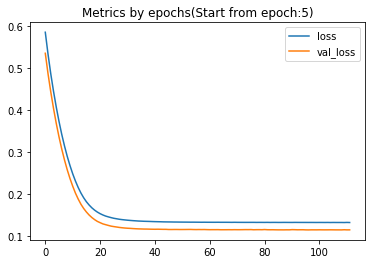

Loading data
Removing columns []
Shapes (1260, 35)
Loading data
Removing columns []
Shapes (420, 35)
Loading data
Removing columns []
Shapes (420, 35)
Columns datasets Index(['triple', 'bgp', 'join', 'leftjoin', 'union', 'filter', 'project',
       'distinct', 'treesize', 'pcs0', 'pcs1', 'pcs2', 'pcs3', 'pcs4', 'pcs5',
       'pcs6', 'pcs7', 'pcs8', 'pcs9', 'pcs10', 'pcs11', 'pcs12', 'pcs13',
       'pcs14', 'pcs15', 'pcs16', 'pcs17', 'pcs18', 'pcs19', 'pcs20', 'pcs21',
       'pcs22', 'pcs23', 'pcs24', 'ex_time'],
      dtype='object')
targets min:0.2 max: 34397.0
targets in log scale min:-1.6094379124341003 max: 10.445724630256212
Shape datasets x: (1260, 34)
Shape datasets xval: (420, 34)
Shape datasets xtest: (420, 34)
Dimensiones de los datos: Cant ejemplos en train:1260, Val: 420 Test: 420
Building Model with input length: 34
Model: "sequential_52"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
d

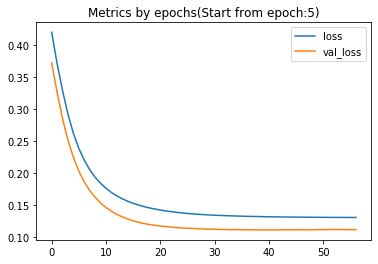

Loading data
Removing columns []
Shapes (1260, 35)
Loading data
Removing columns []
Shapes (420, 35)
Loading data
Removing columns []
Shapes (420, 35)
Columns datasets Index(['triple', 'bgp', 'join', 'leftjoin', 'union', 'filter', 'project',
       'distinct', 'treesize', 'pcs0', 'pcs1', 'pcs2', 'pcs3', 'pcs4', 'pcs5',
       'pcs6', 'pcs7', 'pcs8', 'pcs9', 'pcs10', 'pcs11', 'pcs12', 'pcs13',
       'pcs14', 'pcs15', 'pcs16', 'pcs17', 'pcs18', 'pcs19', 'pcs20', 'pcs21',
       'pcs22', 'pcs23', 'pcs24', 'ex_time'],
      dtype='object')
targets min:0.2 max: 34397.0
targets in log scale min:-1.6094379124341003 max: 10.445724630256212
Shape datasets x: (1260, 34)
Shape datasets xval: (420, 34)
Shape datasets xtest: (420, 34)
Dimensiones de los datos: Cant ejemplos en train:1260, Val: 420 Test: 420
Building Model with input length: 34
Model: "sequential_53"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
d

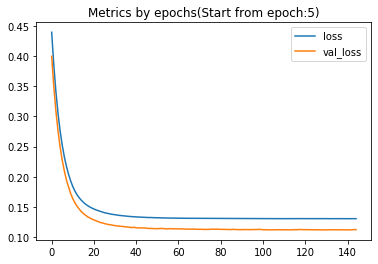

Loading data
Removing columns []
Shapes (1260, 35)
Loading data
Removing columns []
Shapes (420, 35)
Loading data
Removing columns []
Shapes (420, 35)
Columns datasets Index(['triple', 'bgp', 'join', 'leftjoin', 'union', 'filter', 'project',
       'distinct', 'treesize', 'pcs0', 'pcs1', 'pcs2', 'pcs3', 'pcs4', 'pcs5',
       'pcs6', 'pcs7', 'pcs8', 'pcs9', 'pcs10', 'pcs11', 'pcs12', 'pcs13',
       'pcs14', 'pcs15', 'pcs16', 'pcs17', 'pcs18', 'pcs19', 'pcs20', 'pcs21',
       'pcs22', 'pcs23', 'pcs24', 'ex_time'],
      dtype='object')
targets min:0.2 max: 34397.0
targets in log scale min:-1.6094379124341003 max: 10.445724630256212
Shape datasets x: (1260, 34)
Shape datasets xval: (420, 34)
Shape datasets xtest: (420, 34)
Dimensiones de los datos: Cant ejemplos en train:1260, Val: 420 Test: 420
Building Model with input length: 34
Model: "sequential_54"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
d

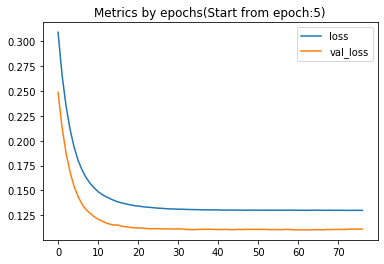

Loading data
Removing columns []
Shapes (1260, 35)
Loading data
Removing columns []
Shapes (420, 35)
Loading data
Removing columns []
Shapes (420, 35)
Columns datasets Index(['triple', 'bgp', 'join', 'leftjoin', 'union', 'filter', 'project',
       'distinct', 'treesize', 'pcs0', 'pcs1', 'pcs2', 'pcs3', 'pcs4', 'pcs5',
       'pcs6', 'pcs7', 'pcs8', 'pcs9', 'pcs10', 'pcs11', 'pcs12', 'pcs13',
       'pcs14', 'pcs15', 'pcs16', 'pcs17', 'pcs18', 'pcs19', 'pcs20', 'pcs21',
       'pcs22', 'pcs23', 'pcs24', 'ex_time'],
      dtype='object')
targets min:0.2 max: 34397.0
targets in log scale min:-1.6094379124341003 max: 10.445724630256212
Shape datasets x: (1260, 34)
Shape datasets xval: (420, 34)
Shape datasets xtest: (420, 34)
Dimensiones de los datos: Cant ejemplos en train:1260, Val: 420 Test: 420
Building Model with input length: 34
Model: "sequential_55"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
d

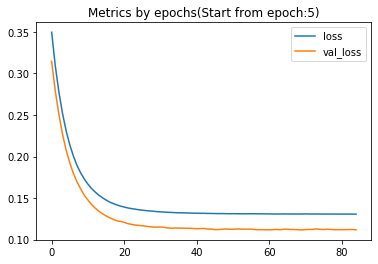

Loading data
Removing columns []
Shapes (1260, 35)
Loading data
Removing columns []
Shapes (420, 35)
Loading data
Removing columns []
Shapes (420, 35)
Columns datasets Index(['triple', 'bgp', 'join', 'leftjoin', 'union', 'filter', 'project',
       'distinct', 'treesize', 'pcs0', 'pcs1', 'pcs2', 'pcs3', 'pcs4', 'pcs5',
       'pcs6', 'pcs7', 'pcs8', 'pcs9', 'pcs10', 'pcs11', 'pcs12', 'pcs13',
       'pcs14', 'pcs15', 'pcs16', 'pcs17', 'pcs18', 'pcs19', 'pcs20', 'pcs21',
       'pcs22', 'pcs23', 'pcs24', 'ex_time'],
      dtype='object')
targets min:0.2 max: 34397.0
targets in log scale min:-1.6094379124341003 max: 10.445724630256212
Shape datasets x: (1260, 34)
Shape datasets xval: (420, 34)
Shape datasets xtest: (420, 34)
Dimensiones de los datos: Cant ejemplos en train:1260, Val: 420 Test: 420
Building Model with input length: 34
Model: "sequential_56"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
d

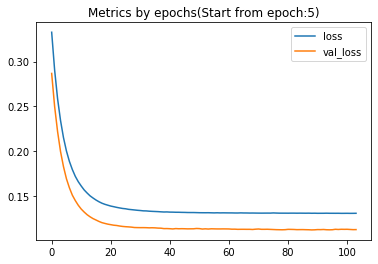

Loading data
Removing columns []
Shapes (1260, 35)
Loading data
Removing columns []
Shapes (420, 35)
Loading data
Removing columns []
Shapes (420, 35)
Columns datasets Index(['triple', 'bgp', 'join', 'leftjoin', 'union', 'filter', 'project',
       'distinct', 'treesize', 'pcs0', 'pcs1', 'pcs2', 'pcs3', 'pcs4', 'pcs5',
       'pcs6', 'pcs7', 'pcs8', 'pcs9', 'pcs10', 'pcs11', 'pcs12', 'pcs13',
       'pcs14', 'pcs15', 'pcs16', 'pcs17', 'pcs18', 'pcs19', 'pcs20', 'pcs21',
       'pcs22', 'pcs23', 'pcs24', 'ex_time'],
      dtype='object')
targets min:0.2 max: 34397.0
targets in log scale min:-1.6094379124341003 max: 10.445724630256212
Shape datasets x: (1260, 34)
Shape datasets xval: (420, 34)
Shape datasets xtest: (420, 34)
Dimensiones de los datos: Cant ejemplos en train:1260, Val: 420 Test: 420
Building Model with input length: 34
Model: "sequential_57"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
d

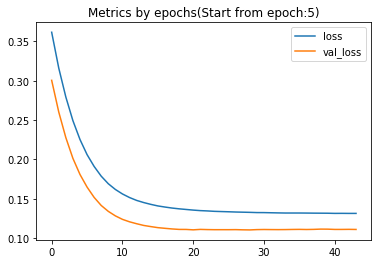

Loading data
Removing columns []
Shapes (1260, 35)
Loading data
Removing columns []
Shapes (420, 35)
Loading data
Removing columns []
Shapes (420, 35)
Columns datasets Index(['triple', 'bgp', 'join', 'leftjoin', 'union', 'filter', 'project',
       'distinct', 'treesize', 'pcs0', 'pcs1', 'pcs2', 'pcs3', 'pcs4', 'pcs5',
       'pcs6', 'pcs7', 'pcs8', 'pcs9', 'pcs10', 'pcs11', 'pcs12', 'pcs13',
       'pcs14', 'pcs15', 'pcs16', 'pcs17', 'pcs18', 'pcs19', 'pcs20', 'pcs21',
       'pcs22', 'pcs23', 'pcs24', 'ex_time'],
      dtype='object')
targets min:0.2 max: 34397.0
targets in log scale min:-1.6094379124341003 max: 10.445724630256212
Shape datasets x: (1260, 34)
Shape datasets xval: (420, 34)
Shape datasets xtest: (420, 34)
Dimensiones de los datos: Cant ejemplos en train:1260, Val: 420 Test: 420
Building Model with input length: 34
Model: "sequential_58"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
d

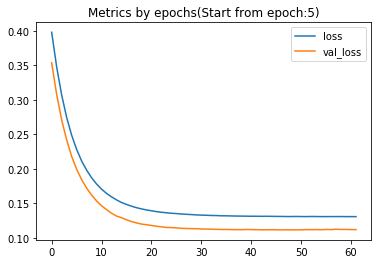

Loading data
Removing columns []
Shapes (1260, 35)
Loading data
Removing columns []
Shapes (420, 35)
Loading data
Removing columns []
Shapes (420, 35)
Columns datasets Index(['triple', 'bgp', 'join', 'leftjoin', 'union', 'filter', 'project',
       'distinct', 'treesize', 'pcs0', 'pcs1', 'pcs2', 'pcs3', 'pcs4', 'pcs5',
       'pcs6', 'pcs7', 'pcs8', 'pcs9', 'pcs10', 'pcs11', 'pcs12', 'pcs13',
       'pcs14', 'pcs15', 'pcs16', 'pcs17', 'pcs18', 'pcs19', 'pcs20', 'pcs21',
       'pcs22', 'pcs23', 'pcs24', 'ex_time'],
      dtype='object')
targets min:0.2 max: 34397.0
targets in log scale min:-1.6094379124341003 max: 10.445724630256212
Shape datasets x: (1260, 34)
Shape datasets xval: (420, 34)
Shape datasets xtest: (420, 34)
Dimensiones de los datos: Cant ejemplos en train:1260, Val: 420 Test: 420
Building Model with input length: 34
Model: "sequential_59"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
d

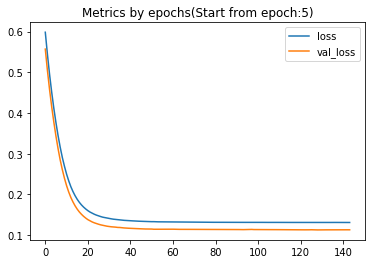

RMSE mean 10 rams: 262.27476489816803
R2 mean 10 rams: 0.9852244132594731


In [19]:
values_rmse = []
values_r2 = []

for i in range(0,10):
    model, scalery, rmse_train, rmse_val, rmse_test, r2_train, r2_val, r2_test = train_complete_model(verbose_train=False, drop_columns=[],units=[85, 90, 55])
    values_rmse.append(rmse_test)
    values_r2.append(r2_test)
print("RMSE mean 10 rams: {}".format(np.mean(values_rmse)))
print("R2 mean 10 rams: {}".format(np.mean(values_r2)))

Loading data
Removing columns []
Shapes (1260, 35)
Loading data
Removing columns []
Shapes (420, 35)
Loading data
Removing columns []
Shapes (420, 35)
Columns datasets Index(['triple', 'bgp', 'join', 'leftjoin', 'union', 'filter', 'project',
       'distinct', 'treesize', 'pcs0', 'pcs1', 'pcs2', 'pcs3', 'pcs4', 'pcs5',
       'pcs6', 'pcs7', 'pcs8', 'pcs9', 'pcs10', 'pcs11', 'pcs12', 'pcs13',
       'pcs14', 'pcs15', 'pcs16', 'pcs17', 'pcs18', 'pcs19', 'pcs20', 'pcs21',
       'pcs22', 'pcs23', 'pcs24', 'ex_time'],
      dtype='object')
targets min:0.2 max: 34397.0
targets in log scale min:-1.6094379124341003 max: 10.445724630256212
Shape datasets x: (1260, 34)
Shape datasets xval: (420, 34)
Shape datasets xtest: (420, 34)
Dimensiones de los datos: Cant ejemplos en train:1260, Val: 420 Test: 420
Building Model with input length: 34
Model: "sequential_98"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
d

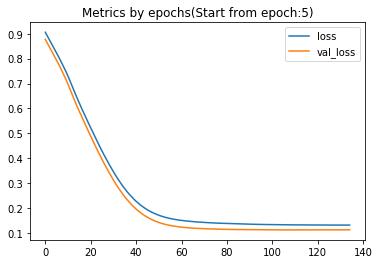

Loading data
Removing columns []
Shapes (1260, 35)
Loading data
Removing columns []
Shapes (420, 35)
Loading data
Removing columns []
Shapes (420, 35)
Columns datasets Index(['triple', 'bgp', 'join', 'leftjoin', 'union', 'filter', 'project',
       'distinct', 'treesize', 'pcs0', 'pcs1', 'pcs2', 'pcs3', 'pcs4', 'pcs5',
       'pcs6', 'pcs7', 'pcs8', 'pcs9', 'pcs10', 'pcs11', 'pcs12', 'pcs13',
       'pcs14', 'pcs15', 'pcs16', 'pcs17', 'pcs18', 'pcs19', 'pcs20', 'pcs21',
       'pcs22', 'pcs23', 'pcs24', 'ex_time'],
      dtype='object')
targets min:0.2 max: 34397.0
targets in log scale min:-1.6094379124341003 max: 10.445724630256212
Shape datasets x: (1260, 34)
Shape datasets xval: (420, 34)
Shape datasets xtest: (420, 34)
Dimensiones de los datos: Cant ejemplos en train:1260, Val: 420 Test: 420
Building Model with input length: 34
Model: "sequential_99"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
d

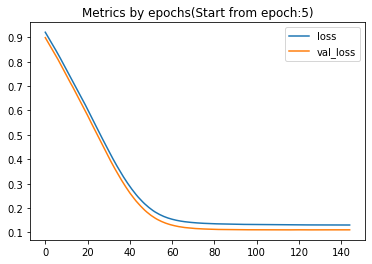

Loading data
Removing columns []
Shapes (1260, 35)
Loading data
Removing columns []
Shapes (420, 35)
Loading data
Removing columns []
Shapes (420, 35)
Columns datasets Index(['triple', 'bgp', 'join', 'leftjoin', 'union', 'filter', 'project',
       'distinct', 'treesize', 'pcs0', 'pcs1', 'pcs2', 'pcs3', 'pcs4', 'pcs5',
       'pcs6', 'pcs7', 'pcs8', 'pcs9', 'pcs10', 'pcs11', 'pcs12', 'pcs13',
       'pcs14', 'pcs15', 'pcs16', 'pcs17', 'pcs18', 'pcs19', 'pcs20', 'pcs21',
       'pcs22', 'pcs23', 'pcs24', 'ex_time'],
      dtype='object')
targets min:0.2 max: 34397.0
targets in log scale min:-1.6094379124341003 max: 10.445724630256212
Shape datasets x: (1260, 34)
Shape datasets xval: (420, 34)
Shape datasets xtest: (420, 34)
Dimensiones de los datos: Cant ejemplos en train:1260, Val: 420 Test: 420
Building Model with input length: 34
Model: "sequential_100"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   


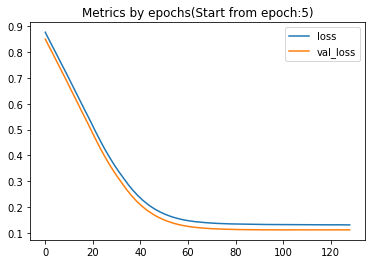

Loading data
Removing columns []
Shapes (1260, 35)
Loading data
Removing columns []
Shapes (420, 35)
Loading data
Removing columns []
Shapes (420, 35)
Columns datasets Index(['triple', 'bgp', 'join', 'leftjoin', 'union', 'filter', 'project',
       'distinct', 'treesize', 'pcs0', 'pcs1', 'pcs2', 'pcs3', 'pcs4', 'pcs5',
       'pcs6', 'pcs7', 'pcs8', 'pcs9', 'pcs10', 'pcs11', 'pcs12', 'pcs13',
       'pcs14', 'pcs15', 'pcs16', 'pcs17', 'pcs18', 'pcs19', 'pcs20', 'pcs21',
       'pcs22', 'pcs23', 'pcs24', 'ex_time'],
      dtype='object')
targets min:0.2 max: 34397.0
targets in log scale min:-1.6094379124341003 max: 10.445724630256212
Shape datasets x: (1260, 34)
Shape datasets xval: (420, 34)
Shape datasets xtest: (420, 34)
Dimensiones de los datos: Cant ejemplos en train:1260, Val: 420 Test: 420
Building Model with input length: 34
Model: "sequential_101"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   


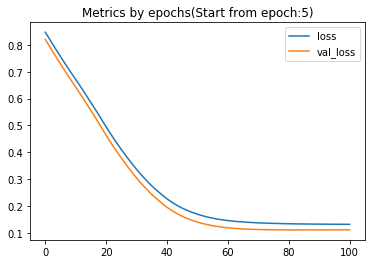

Loading data
Removing columns []
Shapes (1260, 35)
Loading data
Removing columns []
Shapes (420, 35)
Loading data
Removing columns []
Shapes (420, 35)
Columns datasets Index(['triple', 'bgp', 'join', 'leftjoin', 'union', 'filter', 'project',
       'distinct', 'treesize', 'pcs0', 'pcs1', 'pcs2', 'pcs3', 'pcs4', 'pcs5',
       'pcs6', 'pcs7', 'pcs8', 'pcs9', 'pcs10', 'pcs11', 'pcs12', 'pcs13',
       'pcs14', 'pcs15', 'pcs16', 'pcs17', 'pcs18', 'pcs19', 'pcs20', 'pcs21',
       'pcs22', 'pcs23', 'pcs24', 'ex_time'],
      dtype='object')
targets min:0.2 max: 34397.0
targets in log scale min:-1.6094379124341003 max: 10.445724630256212
Shape datasets x: (1260, 34)
Shape datasets xval: (420, 34)
Shape datasets xtest: (420, 34)
Dimensiones de los datos: Cant ejemplos en train:1260, Val: 420 Test: 420
Building Model with input length: 34
Model: "sequential_102"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   


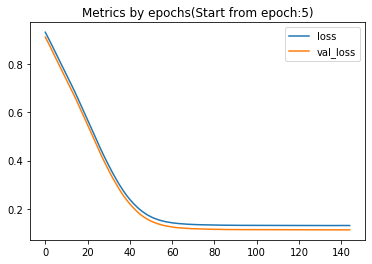

Loading data
Removing columns []
Shapes (1260, 35)
Loading data
Removing columns []
Shapes (420, 35)
Loading data
Removing columns []
Shapes (420, 35)
Columns datasets Index(['triple', 'bgp', 'join', 'leftjoin', 'union', 'filter', 'project',
       'distinct', 'treesize', 'pcs0', 'pcs1', 'pcs2', 'pcs3', 'pcs4', 'pcs5',
       'pcs6', 'pcs7', 'pcs8', 'pcs9', 'pcs10', 'pcs11', 'pcs12', 'pcs13',
       'pcs14', 'pcs15', 'pcs16', 'pcs17', 'pcs18', 'pcs19', 'pcs20', 'pcs21',
       'pcs22', 'pcs23', 'pcs24', 'ex_time'],
      dtype='object')
targets min:0.2 max: 34397.0
targets in log scale min:-1.6094379124341003 max: 10.445724630256212
Shape datasets x: (1260, 34)
Shape datasets xval: (420, 34)
Shape datasets xtest: (420, 34)
Dimensiones de los datos: Cant ejemplos en train:1260, Val: 420 Test: 420
Building Model with input length: 34
Model: "sequential_103"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   


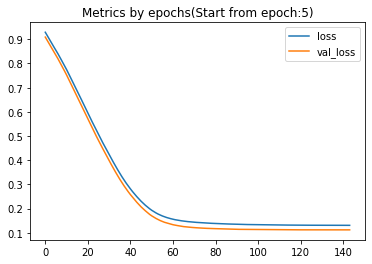

Loading data
Removing columns []
Shapes (1260, 35)
Loading data
Removing columns []
Shapes (420, 35)
Loading data
Removing columns []
Shapes (420, 35)
Columns datasets Index(['triple', 'bgp', 'join', 'leftjoin', 'union', 'filter', 'project',
       'distinct', 'treesize', 'pcs0', 'pcs1', 'pcs2', 'pcs3', 'pcs4', 'pcs5',
       'pcs6', 'pcs7', 'pcs8', 'pcs9', 'pcs10', 'pcs11', 'pcs12', 'pcs13',
       'pcs14', 'pcs15', 'pcs16', 'pcs17', 'pcs18', 'pcs19', 'pcs20', 'pcs21',
       'pcs22', 'pcs23', 'pcs24', 'ex_time'],
      dtype='object')
targets min:0.2 max: 34397.0
targets in log scale min:-1.6094379124341003 max: 10.445724630256212
Shape datasets x: (1260, 34)
Shape datasets xval: (420, 34)
Shape datasets xtest: (420, 34)
Dimensiones de los datos: Cant ejemplos en train:1260, Val: 420 Test: 420
Building Model with input length: 34
Model: "sequential_104"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   


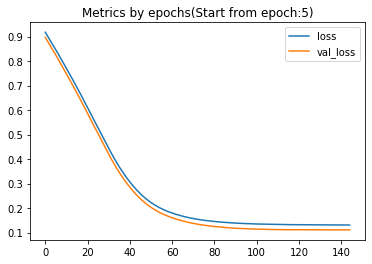

Loading data
Removing columns []
Shapes (1260, 35)
Loading data
Removing columns []
Shapes (420, 35)
Loading data
Removing columns []
Shapes (420, 35)
Columns datasets Index(['triple', 'bgp', 'join', 'leftjoin', 'union', 'filter', 'project',
       'distinct', 'treesize', 'pcs0', 'pcs1', 'pcs2', 'pcs3', 'pcs4', 'pcs5',
       'pcs6', 'pcs7', 'pcs8', 'pcs9', 'pcs10', 'pcs11', 'pcs12', 'pcs13',
       'pcs14', 'pcs15', 'pcs16', 'pcs17', 'pcs18', 'pcs19', 'pcs20', 'pcs21',
       'pcs22', 'pcs23', 'pcs24', 'ex_time'],
      dtype='object')
targets min:0.2 max: 34397.0
targets in log scale min:-1.6094379124341003 max: 10.445724630256212
Shape datasets x: (1260, 34)
Shape datasets xval: (420, 34)
Shape datasets xtest: (420, 34)
Dimensiones de los datos: Cant ejemplos en train:1260, Val: 420 Test: 420
Building Model with input length: 34
Model: "sequential_105"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   


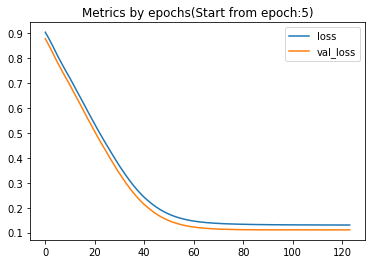

Loading data
Removing columns []
Shapes (1260, 35)
Loading data
Removing columns []
Shapes (420, 35)
Loading data
Removing columns []
Shapes (420, 35)
Columns datasets Index(['triple', 'bgp', 'join', 'leftjoin', 'union', 'filter', 'project',
       'distinct', 'treesize', 'pcs0', 'pcs1', 'pcs2', 'pcs3', 'pcs4', 'pcs5',
       'pcs6', 'pcs7', 'pcs8', 'pcs9', 'pcs10', 'pcs11', 'pcs12', 'pcs13',
       'pcs14', 'pcs15', 'pcs16', 'pcs17', 'pcs18', 'pcs19', 'pcs20', 'pcs21',
       'pcs22', 'pcs23', 'pcs24', 'ex_time'],
      dtype='object')
targets min:0.2 max: 34397.0
targets in log scale min:-1.6094379124341003 max: 10.445724630256212
Shape datasets x: (1260, 34)
Shape datasets xval: (420, 34)
Shape datasets xtest: (420, 34)
Dimensiones de los datos: Cant ejemplos en train:1260, Val: 420 Test: 420
Building Model with input length: 34
Model: "sequential_106"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   


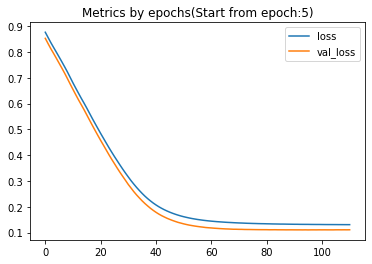

Loading data
Removing columns []
Shapes (1260, 35)
Loading data
Removing columns []
Shapes (420, 35)
Loading data
Removing columns []
Shapes (420, 35)
Columns datasets Index(['triple', 'bgp', 'join', 'leftjoin', 'union', 'filter', 'project',
       'distinct', 'treesize', 'pcs0', 'pcs1', 'pcs2', 'pcs3', 'pcs4', 'pcs5',
       'pcs6', 'pcs7', 'pcs8', 'pcs9', 'pcs10', 'pcs11', 'pcs12', 'pcs13',
       'pcs14', 'pcs15', 'pcs16', 'pcs17', 'pcs18', 'pcs19', 'pcs20', 'pcs21',
       'pcs22', 'pcs23', 'pcs24', 'ex_time'],
      dtype='object')
targets min:0.2 max: 34397.0
targets in log scale min:-1.6094379124341003 max: 10.445724630256212
Shape datasets x: (1260, 34)
Shape datasets xval: (420, 34)
Shape datasets xtest: (420, 34)
Dimensiones de los datos: Cant ejemplos en train:1260, Val: 420 Test: 420
Building Model with input length: 34
Model: "sequential_107"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   


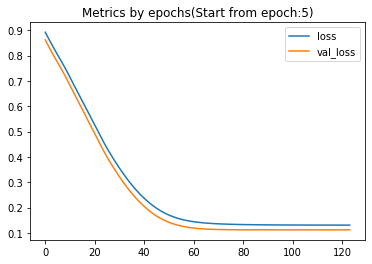

RMSE mean 10 rams: 262.03514619822147
R2 mean 10 rams: 0.985270133132957


In [34]:
values_rmse = []
values_r2 = []

for i in range(0,10):
    optim = Adam(lr=0.00001)
    model, scalery, rmse_train, rmse_val, rmse_test, r2_train, r2_val, r2_test = train_complete_model(verbose_train=False, optimizer=optim, drop_columns=[],units=[85, 60, 60])
    values_rmse.append(rmse_test)
    values_r2.append(r2_test)
print("RMSE mean 10 rams: {}".format(np.mean(values_rmse)))
print("R2 mean 10 rams: {}".format(np.mean(values_r2)))

<span style="color:blue">
    
### Best Configuration
- Optimizer: SGD with learning rate 0.001.
- 3 layers with [85, 80, 60] units.
- first layer: initialization random uniform.
- we execute 10 runs and calculate the mean for result reports.
</span>

Loading data
Removing columns []
Shapes (1260, 35)
Loading data
Removing columns []
Shapes (420, 35)
Loading data
Removing columns []
Shapes (420, 35)
Columns datasets Index(['triple', 'bgp', 'join', 'leftjoin', 'union', 'filter', 'project',
       'distinct', 'treesize', 'pcs0', 'pcs1', 'pcs2', 'pcs3', 'pcs4', 'pcs5',
       'pcs6', 'pcs7', 'pcs8', 'pcs9', 'pcs10', 'pcs11', 'pcs12', 'pcs13',
       'pcs14', 'pcs15', 'pcs16', 'pcs17', 'pcs18', 'pcs19', 'pcs20', 'pcs21',
       'pcs22', 'pcs23', 'pcs24', 'ex_time'],
      dtype='object')
targets min:0.2 max: 34397.0
targets in log scale min:-1.6094379124341003 max: 10.445724630256212
Shape datasets x: (1260, 34)
Shape datasets xval: (420, 34)
Shape datasets xtest: (420, 34)
Dimensiones de los datos: Cant ejemplos en train:1260, Val: 420 Test: 420
Building Model with input length: 34
Model: "sequential_116"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   


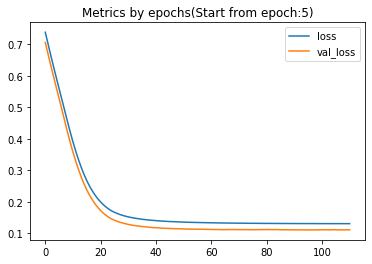

Loading data
Removing columns []
Shapes (1260, 35)
Loading data
Removing columns []
Shapes (420, 35)
Loading data
Removing columns []
Shapes (420, 35)
Columns datasets Index(['triple', 'bgp', 'join', 'leftjoin', 'union', 'filter', 'project',
       'distinct', 'treesize', 'pcs0', 'pcs1', 'pcs2', 'pcs3', 'pcs4', 'pcs5',
       'pcs6', 'pcs7', 'pcs8', 'pcs9', 'pcs10', 'pcs11', 'pcs12', 'pcs13',
       'pcs14', 'pcs15', 'pcs16', 'pcs17', 'pcs18', 'pcs19', 'pcs20', 'pcs21',
       'pcs22', 'pcs23', 'pcs24', 'ex_time'],
      dtype='object')
targets min:0.2 max: 34397.0
targets in log scale min:-1.6094379124341003 max: 10.445724630256212
Shape datasets x: (1260, 34)
Shape datasets xval: (420, 34)
Shape datasets xtest: (420, 34)
Dimensiones de los datos: Cant ejemplos en train:1260, Val: 420 Test: 420
Building Model with input length: 34
Model: "sequential_117"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   


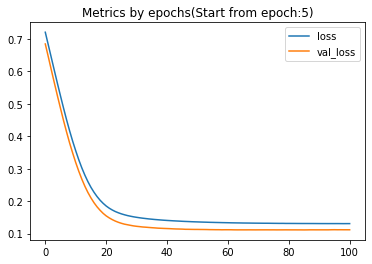

Loading data
Removing columns []
Shapes (1260, 35)
Loading data
Removing columns []
Shapes (420, 35)
Loading data
Removing columns []
Shapes (420, 35)
Columns datasets Index(['triple', 'bgp', 'join', 'leftjoin', 'union', 'filter', 'project',
       'distinct', 'treesize', 'pcs0', 'pcs1', 'pcs2', 'pcs3', 'pcs4', 'pcs5',
       'pcs6', 'pcs7', 'pcs8', 'pcs9', 'pcs10', 'pcs11', 'pcs12', 'pcs13',
       'pcs14', 'pcs15', 'pcs16', 'pcs17', 'pcs18', 'pcs19', 'pcs20', 'pcs21',
       'pcs22', 'pcs23', 'pcs24', 'ex_time'],
      dtype='object')
targets min:0.2 max: 34397.0
targets in log scale min:-1.6094379124341003 max: 10.445724630256212
Shape datasets x: (1260, 34)
Shape datasets xval: (420, 34)
Shape datasets xtest: (420, 34)
Dimensiones de los datos: Cant ejemplos en train:1260, Val: 420 Test: 420
Building Model with input length: 34
Model: "sequential_118"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   


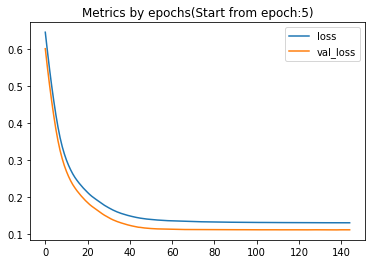

Loading data
Removing columns []
Shapes (1260, 35)
Loading data
Removing columns []
Shapes (420, 35)
Loading data
Removing columns []
Shapes (420, 35)
Columns datasets Index(['triple', 'bgp', 'join', 'leftjoin', 'union', 'filter', 'project',
       'distinct', 'treesize', 'pcs0', 'pcs1', 'pcs2', 'pcs3', 'pcs4', 'pcs5',
       'pcs6', 'pcs7', 'pcs8', 'pcs9', 'pcs10', 'pcs11', 'pcs12', 'pcs13',
       'pcs14', 'pcs15', 'pcs16', 'pcs17', 'pcs18', 'pcs19', 'pcs20', 'pcs21',
       'pcs22', 'pcs23', 'pcs24', 'ex_time'],
      dtype='object')
targets min:0.2 max: 34397.0
targets in log scale min:-1.6094379124341003 max: 10.445724630256212
Shape datasets x: (1260, 34)
Shape datasets xval: (420, 34)
Shape datasets xtest: (420, 34)
Dimensiones de los datos: Cant ejemplos en train:1260, Val: 420 Test: 420
Building Model with input length: 34
Model: "sequential_119"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   


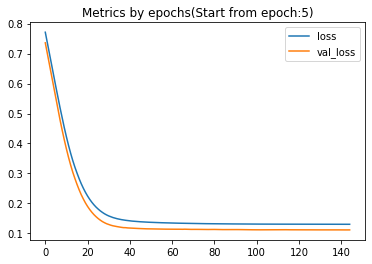

Loading data
Removing columns []
Shapes (1260, 35)
Loading data
Removing columns []
Shapes (420, 35)
Loading data
Removing columns []
Shapes (420, 35)
Columns datasets Index(['triple', 'bgp', 'join', 'leftjoin', 'union', 'filter', 'project',
       'distinct', 'treesize', 'pcs0', 'pcs1', 'pcs2', 'pcs3', 'pcs4', 'pcs5',
       'pcs6', 'pcs7', 'pcs8', 'pcs9', 'pcs10', 'pcs11', 'pcs12', 'pcs13',
       'pcs14', 'pcs15', 'pcs16', 'pcs17', 'pcs18', 'pcs19', 'pcs20', 'pcs21',
       'pcs22', 'pcs23', 'pcs24', 'ex_time'],
      dtype='object')
targets min:0.2 max: 34397.0
targets in log scale min:-1.6094379124341003 max: 10.445724630256212
Shape datasets x: (1260, 34)
Shape datasets xval: (420, 34)
Shape datasets xtest: (420, 34)
Dimensiones de los datos: Cant ejemplos en train:1260, Val: 420 Test: 420
Building Model with input length: 34
Model: "sequential_120"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   


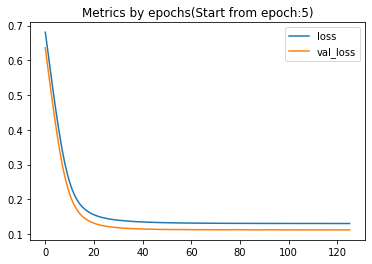

Loading data
Removing columns []
Shapes (1260, 35)
Loading data
Removing columns []
Shapes (420, 35)
Loading data
Removing columns []
Shapes (420, 35)
Columns datasets Index(['triple', 'bgp', 'join', 'leftjoin', 'union', 'filter', 'project',
       'distinct', 'treesize', 'pcs0', 'pcs1', 'pcs2', 'pcs3', 'pcs4', 'pcs5',
       'pcs6', 'pcs7', 'pcs8', 'pcs9', 'pcs10', 'pcs11', 'pcs12', 'pcs13',
       'pcs14', 'pcs15', 'pcs16', 'pcs17', 'pcs18', 'pcs19', 'pcs20', 'pcs21',
       'pcs22', 'pcs23', 'pcs24', 'ex_time'],
      dtype='object')
targets min:0.2 max: 34397.0
targets in log scale min:-1.6094379124341003 max: 10.445724630256212
Shape datasets x: (1260, 34)
Shape datasets xval: (420, 34)
Shape datasets xtest: (420, 34)
Dimensiones de los datos: Cant ejemplos en train:1260, Val: 420 Test: 420
Building Model with input length: 34
Model: "sequential_121"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   


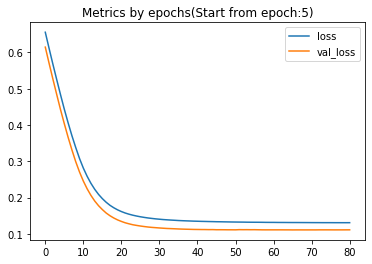

Loading data
Removing columns []
Shapes (1260, 35)
Loading data
Removing columns []
Shapes (420, 35)
Loading data
Removing columns []
Shapes (420, 35)
Columns datasets Index(['triple', 'bgp', 'join', 'leftjoin', 'union', 'filter', 'project',
       'distinct', 'treesize', 'pcs0', 'pcs1', 'pcs2', 'pcs3', 'pcs4', 'pcs5',
       'pcs6', 'pcs7', 'pcs8', 'pcs9', 'pcs10', 'pcs11', 'pcs12', 'pcs13',
       'pcs14', 'pcs15', 'pcs16', 'pcs17', 'pcs18', 'pcs19', 'pcs20', 'pcs21',
       'pcs22', 'pcs23', 'pcs24', 'ex_time'],
      dtype='object')
targets min:0.2 max: 34397.0
targets in log scale min:-1.6094379124341003 max: 10.445724630256212
Shape datasets x: (1260, 34)
Shape datasets xval: (420, 34)
Shape datasets xtest: (420, 34)
Dimensiones de los datos: Cant ejemplos en train:1260, Val: 420 Test: 420
Building Model with input length: 34
Model: "sequential_122"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   


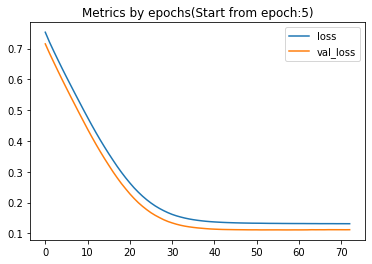

Loading data
Removing columns []
Shapes (1260, 35)
Loading data
Removing columns []
Shapes (420, 35)
Loading data
Removing columns []
Shapes (420, 35)
Columns datasets Index(['triple', 'bgp', 'join', 'leftjoin', 'union', 'filter', 'project',
       'distinct', 'treesize', 'pcs0', 'pcs1', 'pcs2', 'pcs3', 'pcs4', 'pcs5',
       'pcs6', 'pcs7', 'pcs8', 'pcs9', 'pcs10', 'pcs11', 'pcs12', 'pcs13',
       'pcs14', 'pcs15', 'pcs16', 'pcs17', 'pcs18', 'pcs19', 'pcs20', 'pcs21',
       'pcs22', 'pcs23', 'pcs24', 'ex_time'],
      dtype='object')
targets min:0.2 max: 34397.0
targets in log scale min:-1.6094379124341003 max: 10.445724630256212
Shape datasets x: (1260, 34)
Shape datasets xval: (420, 34)
Shape datasets xtest: (420, 34)
Dimensiones de los datos: Cant ejemplos en train:1260, Val: 420 Test: 420
Building Model with input length: 34
Model: "sequential_123"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   


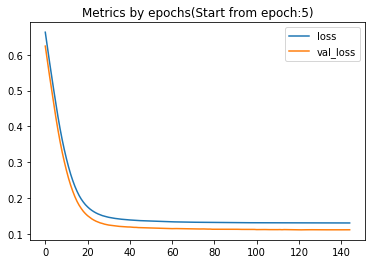

Loading data
Removing columns []
Shapes (1260, 35)
Loading data
Removing columns []
Shapes (420, 35)
Loading data
Removing columns []
Shapes (420, 35)
Columns datasets Index(['triple', 'bgp', 'join', 'leftjoin', 'union', 'filter', 'project',
       'distinct', 'treesize', 'pcs0', 'pcs1', 'pcs2', 'pcs3', 'pcs4', 'pcs5',
       'pcs6', 'pcs7', 'pcs8', 'pcs9', 'pcs10', 'pcs11', 'pcs12', 'pcs13',
       'pcs14', 'pcs15', 'pcs16', 'pcs17', 'pcs18', 'pcs19', 'pcs20', 'pcs21',
       'pcs22', 'pcs23', 'pcs24', 'ex_time'],
      dtype='object')
targets min:0.2 max: 34397.0
targets in log scale min:-1.6094379124341003 max: 10.445724630256212
Shape datasets x: (1260, 34)
Shape datasets xval: (420, 34)
Shape datasets xtest: (420, 34)
Dimensiones de los datos: Cant ejemplos en train:1260, Val: 420 Test: 420
Building Model with input length: 34
Model: "sequential_124"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   


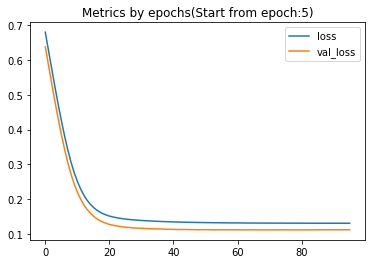

Loading data
Removing columns []
Shapes (1260, 35)
Loading data
Removing columns []
Shapes (420, 35)
Loading data
Removing columns []
Shapes (420, 35)
Columns datasets Index(['triple', 'bgp', 'join', 'leftjoin', 'union', 'filter', 'project',
       'distinct', 'treesize', 'pcs0', 'pcs1', 'pcs2', 'pcs3', 'pcs4', 'pcs5',
       'pcs6', 'pcs7', 'pcs8', 'pcs9', 'pcs10', 'pcs11', 'pcs12', 'pcs13',
       'pcs14', 'pcs15', 'pcs16', 'pcs17', 'pcs18', 'pcs19', 'pcs20', 'pcs21',
       'pcs22', 'pcs23', 'pcs24', 'ex_time'],
      dtype='object')
targets min:0.2 max: 34397.0
targets in log scale min:-1.6094379124341003 max: 10.445724630256212
Shape datasets x: (1260, 34)
Shape datasets xval: (420, 34)
Shape datasets xtest: (420, 34)
Dimensiones de los datos: Cant ejemplos en train:1260, Val: 420 Test: 420
Building Model with input length: 34
Model: "sequential_125"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   


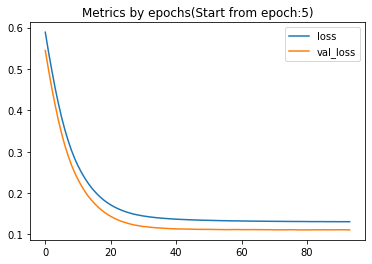

RMSE mean 10 rams: 258.06532943931444
R2 mean 10 rams: 0.9857154731413313


In [37]:
values_rmse = []
values_r2 = []

for i in range(0,10):
    optim = SGD(lr=0.001)
    model, scalery, rmse_train, rmse_val, rmse_test, r2_train, r2_val, r2_test = train_complete_model(verbose_train=False, optimizer=optim, drop_columns=[],units=[85, 80, 60])
    values_rmse.append(rmse_test)
    values_r2.append(r2_test)
print("RMSE mean 10 rams: {}".format(np.mean(values_rmse)))
print("R2 mean 10 rams: {}".format(np.mean(values_r2)))